## Instruction

> 1. Rename assignment-02-###-###.ipynb where ### is your student ID and your name (Chinese).
> 2. The deadline of Assignment-02 is 23:59pm, 04-16-2025
>
> 3. In this assignment, you will
>    1) train word embedding
>    2) build document embedding
>    3) build language models using LSTMs
>
> enwiki-train.json and enwiki-test.json are from the Assignment-01 folder. In the data file, each line contains a Wikipedia page with attributes, title, label, and text. There are 9000 records in the train file and 1000 records in test file with ten categories. We use treebank-train.txt as our training text for building a language model.

In [1]:
import numpy as np
import json


In [67]:
# In this assignment, you will use word embeddings to explore our Wikipedia dataset.
np.random.seed(0)
wiki_data = []
with open("../data/enwiki-train.json","r") as f:
    for each_line in f:
        record = json.loads(each_line)
        wiki_data.append(record)
print(len(wiki_data))
label_counts = dict()
for item in wiki_data:
    if item['label'] not in label_counts:
        label_counts[item['label']] = 0
    label_counts[item['label']] += 1
print(f"label, counts")
for item in label_counts:
    print(f"{item},{label_counts[item]}")


wiki_data_test = []
with open("../data/enwiki-test.json","r") as f:
    for each_line in f:
        record = json.loads(each_line)
        wiki_data_test.append(record)


9000
label, counts
Book,858
Food,121
Film,2752
Politician,3441
Animal,82
Writer,769
Artist,457
Disease,202
Actor,79
Software,239


## Task 1 - Train word embeddings using SGNS

> 1) Use our enwiki-train.json as training data.
> 
> You can use the Gensim tool  (https://radimrehurek.com/gensim/models/word2vec.html). We also encourage you to implement it yourself. You should explain how hyper-parameters such as dimensionality of embeddings, window size, the parameter of negative sampling strategy, and initial learning rate have been chosen.
> 
> Text preprocessing: you can preprocess text, for example lowercasing or using min_count to control the vocabulary size

In [4]:
# Your code goes to here
import nltk
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm

#下载完一次就再也不需要重复下载了，已经进到我们的文件夹里面了
# # 先下载基础包
# nltk.download('punkt', force=True)
# # 再下载缺失的附加数据
# nltk.download('punkt_tab')  # 这是关键！

# # 示例文本
# text = "NLTK is a powerful Python library for natural language processing."
# # 分词
# tokens = word_tokenize(text)
# print(tokens)



# 注意只能对字符串进行分词
tokenized_data = []
for item in tqdm(wiki_data, desc="处理进度"):  
    title = item["title"]
    label = item["label"]
    text = word_tokenize(item["text"])
    tokenized_data.append({"title": title, "label": label, "text": text})
print(len(tokenized_data))


处理进度: 100%|██████████| 9000/9000 [02:03<00:00, 72.97it/s]

9000


In [6]:
#一点点预处理
sentences = [
    [word.lower() for word in item["text"]]  # 只做小写转换
    for item in tokenized_data
]

In [8]:
from gensim.models import Word2Vec
from tqdm import tqdm
import numpy as np

model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=5,
    min_count=5,
    workers=4,
    epochs=10
)

# 手动显示进度
for epoch in range(10):
    model.train(
        sentences,
        total_examples=len(sentences),
        epochs=1,
        start_alpha=model.alpha,
        end_alpha=model.min_alpha
    )
    print(f"Epoch {epoch+1}/10, Loss: {model.get_latest_training_loss():.4f}")

# 保存模型
model.save("word2vec.model")

# 测试：查找与"nlp"最相似的5个词
print("\n与'nlp'最相似的词：")
if "nlp" in model.wv.key_to_index:
    for word, score in model.wv.most_similar("nlp", topn=5):
        print(f"{word}: {score:.2f}")
else:
    print("词汇表中不存在'nlp'，请使用数据中存在的词汇测试")

Epoch 1/10, Loss: 0.0000
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000

与'nlp'最相似的词：
object-oriented: 0.46
ieee: 0.45
computational: 0.44
electron: 0.44
dbms: 0.42


In [9]:
# 测试：查找与"nlp"最相似的5个词

if "a" in model.wv.key_to_index:
    for word, score in model.wv.most_similar("a", topn=5):
        print(f"{word}: {score:.2f}")
else:
    print("词汇表中不存在'nlp'，请使用数据中存在的词汇测试")

another: 0.56
the: 0.44
—a: 0.40
an: 0.39
this: 0.37


> 2) Find similar/dissimilar word pairs: Randomly generate 10000 word pairs from your built vocabularies. Print 5 closest word pairs and 5 furthest word pairs (you can use cosine-similarity to measure two words). Explain your findings.

In [10]:
# Your code goes to here
from sklearn.metrics.pairwise import cosine_similarity#去计算余弦相似度




# 关于word2vector的接口：
# 1. 词向量相关方法
# model.wv[key] - 获取单词的向量表示
# model.wv.most_similar(word, topn=10) - 查找最相似的词
# model.wv.similarity(word1, word2) - 计算两个词的余弦相似度
# model.wv.doesnt_match(words) - 找出列表中不匹配的词
# model.wv.distance(word1, word2) - 计算两个词的距离(1-相似度)
# 2. 词汇表相关
# model.wv.key_to_index - 词到索引的字典
# model.wv.index_to_key - 索引到词的列表
# model.wv.vocab - 词汇表(旧版本)
# model.wv.vectors - 所有词向量组成的矩阵
# 3. 模型操作
# model.save(path) - 保存模型
# Word2Vec.load(path) - 加载模型
# model.train(...) - 继续训练模型
# 4. 其他实用方法
# model.wv.n_similarity(ws1, ws2) - 计算两组词的平均相似度
# model.wv.evaluate_word_pairs(pairs) - 评估词对相关性
# model.wv.get_normed_vectors() - 获取归一化后的向量


my_vocab=list(model.wv.key_to_index.keys())
np.random.seed(42)  # 确保可重复性
random_pairs = [tuple(np.random.choice(my_vocab, 2, replace=False)) for _ in range(10000)]

pair_similarities=[]
for word1,word2 in random_pairs:
    sim = model.wv.similarity(word1, word2)
    pair_similarities.append((word1, word2, sim))
    
sorted_pairs = sorted(pair_similarities, key=lambda x: x[2])#按照第二项sim从小到大排序
furthest=sorted_pairs[0:5:1]
clothest=sorted_pairs[-5::1]#不能写sorted_pairs[-5:0:1]

print("5个最相似的词对:")
for word1,word2,sim in clothest:
    print(f"{word1}-{word2}: {sim:.4f}")
    
print("\n5个最不相似的词对:")
for word1,word2,sim in furthest:
    print(f"{word1}-{word2}: {sim:.4f}")

5个最相似的词对:
sukartono-ivitch: 0.4200
4.9/10-titch: 0.4209
artisanal-dressings: 0.4290
long-acting-relapsed: 0.4581
goliyon-missiamma: 0.4690

5个最不相似的词对:
meehan-fair-skinned: -0.2207
federalism-tsosie: -0.2142
facilitation-ilaiyaraaja: -0.2108
falls-petitions: -0.2076
thunder-multi-ethnic: -0.2052


## Task 2 - Classify documents using embeddings

> For each document (both training and testing documents), you have several choices to generate a document embedding from the embedding we trained in Task 1 (Just choose one of them):

> - Use the average of embeddings of all words in each document.
> - Use the first paragraph’s words and take an average on these embeddings.
> - Use the doc2vec algorithm to present each document.
> - etc...

> Build a classifer on training documents and testing this classifer on testing documents. Since you have the ground truth, you can use the Micro/Macro F1-score to measure the performance of these choices on testing documents.

In [68]:
# Your code goes to here
import numpy as np

def label_and_idx(wiki_data):
    set_for_label=set()
    for item in wiki_data:
        set_for_label.add(item["label"])
    label_to_idx={}
    idx_to_label={}
    for idx,label in enumerate(set_for_label):#注意:enumerate返回的是idx,元素   不要把顺序搞反了
        label_to_idx[label]=idx
        idx_to_label[idx]=label
    return label_to_idx,idx_to_label

label_to_idx,idx_to_label=label_and_idx(wiki_data)

label_to_idx_test,idx_to_label_test=label_and_idx(wiki_data_test)

# 在实际开发的时候，一开始就想到了对于单个文档的处理比较舒服，那么就先处理单个文档，后续再进行多个文档的处理
# 而且我们可以先不用封装为函数,先把代码舒服地写完再去封装
def vec_for_doc(doc):
    sum_vec = np.zeros(300)  
    valid_words = 0  
    for token in doc["text"]:
        if token in model.wv:  
            sum_vec += model.wv[token]
            valid_words += 1
    return sum_vec/valid_words

# print(vec_for_doc(wiki_data[0]))

def vec_for_docs(docs,label_to_idx):
    vec_idx={}
    for doc in tqdm(docs, desc="Processing docs"): 
        label=doc["label"]
        idx=label_to_idx[label]
        vec=vec_for_doc(doc)
        vec_idx[tuple(vec)]=idx#要加tuple(vec),因为vec是np数组,是一个可变对象,那么就是不可以做为dict的键使用list(vec)也不行
    return vec_idx

# print(vec_for_docs(wiki_data[:10]))

doc_train_data=vec_for_docs(wiki_data,label_to_idx)
doc_test_data=vec_for_docs(wiki_data_test,label_to_idx_test)

Processing docs: 100%|██████████| 1000/1000 [00:41<00:00, 24.34it/s]


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset#用于数据打包
from torch.utils.data import DataLoader#用于`数据`加载
# from tqdm.auto import tqdm  # 使用auto适配环境
from tqdm import tqdm 

def load_data(doc_train_data):#可以考虑这样子去封装函数(形参就是我们第一次写这个函数时用到的实参)
    inputs = torch.stack([torch.tensor(vec) for vec in doc_train_data.keys()])#stack是把张量进行堆叠
    targets = torch.tensor(list(doc_train_data.values()), dtype=torch.long)
    mydataset = TensorDataset(inputs, targets)
    train_loader = DataLoader(mydataset, batch_size=32,shuffle=True)#在每次迭代时会传入一个batch的数据
    return train_loader

train_DataLoader=load_data(doc_train_data)
test_DataLoader=load_data(doc_test_data)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#我们需要手动指定torch在gpu上计算,不手动指定就还是在cpu上面的

classificationNet=nn.Sequential(
    nn.Flatten(),
    nn.Linear(300,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(256,10)).to(device)# 将网络移动到GPU


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
classificationNet.apply(init_weights) #这样子对net的每一层都初始化

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 多分类交叉熵损失,自带Softmax,适用于多分类,会直接输出一个数字
optimizer = optim.Adam(classificationNet.parameters(), lr=0.001)  #注意要绑定网络的参数


def train_classification(num_epochs,device):
    classificationNet.train()  # 设置为训练模式
    for epoch in range(num_epochs):
        total_loss=0.0
        # 添加tqdm进度条,每一轮epoch就更新一下
        progress_bar = tqdm(train_DataLoader, leave=False,desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True)
        for batch_inputs,batch_labels in train_DataLoader:
            batch_inputs = batch_inputs.to(device).float() # 要把数据手动转移到GPU  
            batch_labels = batch_labels.to(device)
            optimizer.zero_grad()     #每个batch清理一次梯度,因为我们是使用一个batch的数据进行训练的,如果不清理,当前batch的训练就会与上一个batch的数据相关
            y_pred=classificationNet(batch_inputs)
            loss=criterion(y_pred,batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()#要使用item(),因为如果total_loss += loss，这可能会导致显存不断增加，因为PyTorch会将这些操作视为计算图的一部分
        avg_loss = total_loss / len(train_DataLoader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")
            
train_classification(20,device)



Epoch 1/20:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch [1/20], Avg Loss: 1.7550


Epoch [2/20], Avg Loss: 1.6839


Epoch 3/20:   0%|          | 0/282 [00:00<?, ?it/s]
                                                

Epoch [3/20], Avg Loss: 1.6547


Epoch [4/20], Avg Loss: 1.6194


Epoch 5/20:   0%|          | 0/282 [00:00<?, ?it/s]
                                                

Epoch [5/20], Avg Loss: 1.5722


Epoch [6/20], Avg Loss: 1.5272


Epoch 7/20:   0%|          | 0/282 [00:00<?, ?it/s]
                                                

Epoch [7/20], Avg Loss: 1.4937


Epoch [8/20], Avg Loss: 1.4720


Epoch 9/20:   0%|          | 0/282 [00:00<?, ?it/s]
                                                

Epoch [9/20], Avg Loss: 1.4654



                                                   ]

Epoch [10/20], Avg Loss: 1.4681


Epoch 11/20:   0%|          | 0/282 [00:00<?, ?it/s]
                                                 

Epoch [11/20], Avg Loss: 1.4691


Epoch [12/20], Avg Loss: 1.4575


Epoch 13/20:   0%|          | 0/282 [00:00<?, ?it/s]
                                                 

Epoch [13/20], Avg Loss: 1.4481


Epoch [14/20], Avg Loss: 1.4295


Epoch 15/20:   0%|          | 0/282 [00:00<?, ?it/s]
                                                 

Epoch [15/20], Avg Loss: 1.4397


Epoch [16/20], Avg Loss: 1.4440


Epoch 17/20:   0%|          | 0/282 [00:00<?, ?it/s]
                                                 

Epoch [17/20], Avg Loss: 1.4350


Epoch [18/20], Avg Loss: 1.4175


Epoch 19/20:   0%|          | 0/282 [00:00<?, ?it/s]
                                                 

Epoch [19/20], Avg Loss: 1.4279


Epoch [20/20], Avg Loss: 1.4352


In [78]:
#还要在test上进行测试
from sklearn.metrics import f1_score, classification_report
def evaluate_classification(device, data_loader, mode='test'):
    classificationNet.eval()  # 设置为评估模式
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for batch_inputs, batch_labels in tqdm(data_loader, desc=f"Evaluating {mode} set"):
            batch_inputs = batch_inputs.to(device).float()
            batch_labels = batch_labels.to(device)
            
            outputs = classificationNet(batch_inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            true_labels.extend(batch_labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
    
    # 计算评估指标
    micro_f1 = f1_score(true_labels, pred_labels, average='micro')
    macro_f1 = f1_score(true_labels, pred_labels, average='macro')
    
    print(f"\n{mode.capitalize()} Set Evaluation:")
    print(f"Micro F1-score: {micro_f1:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=[idx_to_label[i] for i in sorted(idx_to_label.keys())]))
    
    return micro_f1, macro_f1

# 评估模型
print("\nEvaluating on training set...")
train_micro_f1, train_macro_f1 = evaluate_classification(device, train_DataLoader, 'train')

print("\nEvaluating on test set...")
test_micro_f1, test_macro_f1 = evaluate_classification(device, test_DataLoader, 'test')


Evaluating on training set...


Evaluating train set: 100%|██████████| 282/282 [00:00<00:00, 1923.30it/s]
/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha


Train Set Evaluation:
Micro F1-score: 0.6206
Macro F1-score: 0.1491

Classification Report:
              precision    recall  f1-score   support

        Film       0.48      0.98      0.64      2752
        Book       0.00      0.00      0.00       858
      Artist       0.00      0.00      0.00       457
        Food       0.00      0.00      0.00       121
       Actor       0.00      0.00      0.00        79
  Politician       0.86      0.84      0.85      3441
      Animal       0.00      0.00      0.00        82
     Disease       0.00      0.00      0.00       202
    Software       0.00      0.00      0.00       239
      Writer       0.00      0.00      0.00       769

    accuracy                           0.62      9000
   macro avg       0.13      0.18      0.15      9000
weighted avg       0.47      0.62      0.52      9000


Evaluating on test set...


Evaluating test set: 100%|██████████| 32/32 [00:00<00:00, 1893.14it/s]


Test Set Evaluation:
Micro F1-score: 0.6140
Macro F1-score: 0.1484

Classification Report:
              precision    recall  f1-score   support

        Film       0.46      0.97      0.63       296
        Book       0.00      0.00      0.00       117
      Artist       0.00      0.00      0.00        63
        Food       0.00      0.00      0.00        16
       Actor       0.00      0.00      0.00         1
  Politician       0.86      0.85      0.86       383
      Animal       0.00      0.00      0.00        18
     Disease       0.00      0.00      0.00        11
    Software       0.00      0.00      0.00        27
      Writer       0.00      0.00      0.00        68

    accuracy                           0.61      1000
   macro avg       0.13      0.18      0.15      1000
weighted avg       0.47      0.61      0.51      1000




/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

## Task 3 - Use t-SNE to project training document embeddings

> Use t-SNE to project these doc vectors into 2-d and plot them out for each of the above choices. Each point should have a specific color (represent a particular class). You may need to try different parameters of t-SNE. One can find more details about t-SNE in this excellent article (https://distill.pub/2016/misread-tsne/ (Links to an external site.)).

Visualizing document embeddings (average word vectors method)


/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


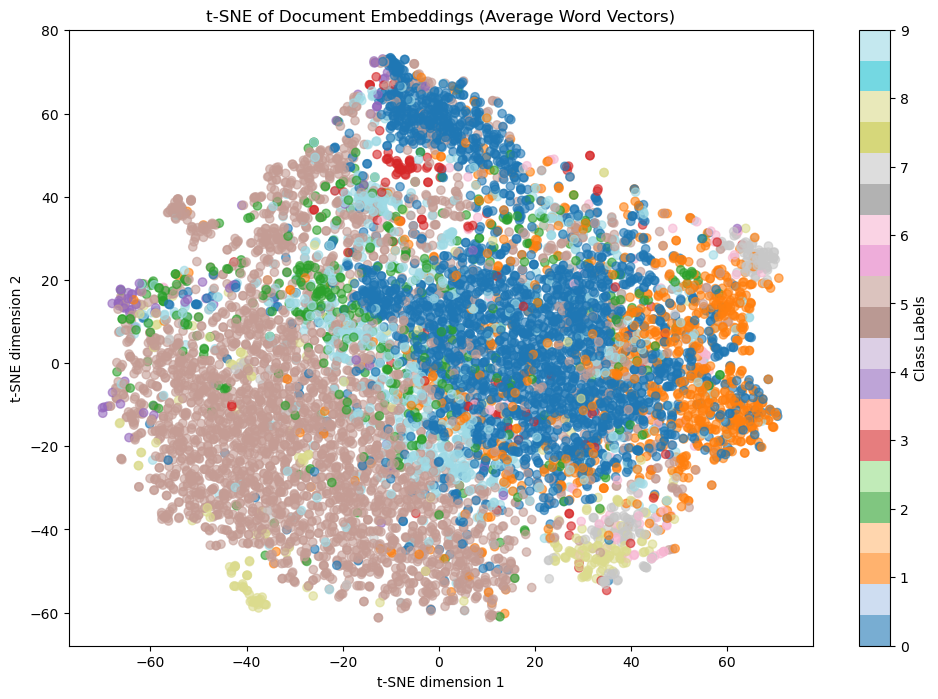

Visualizing document embeddings (average word vectors method)


/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


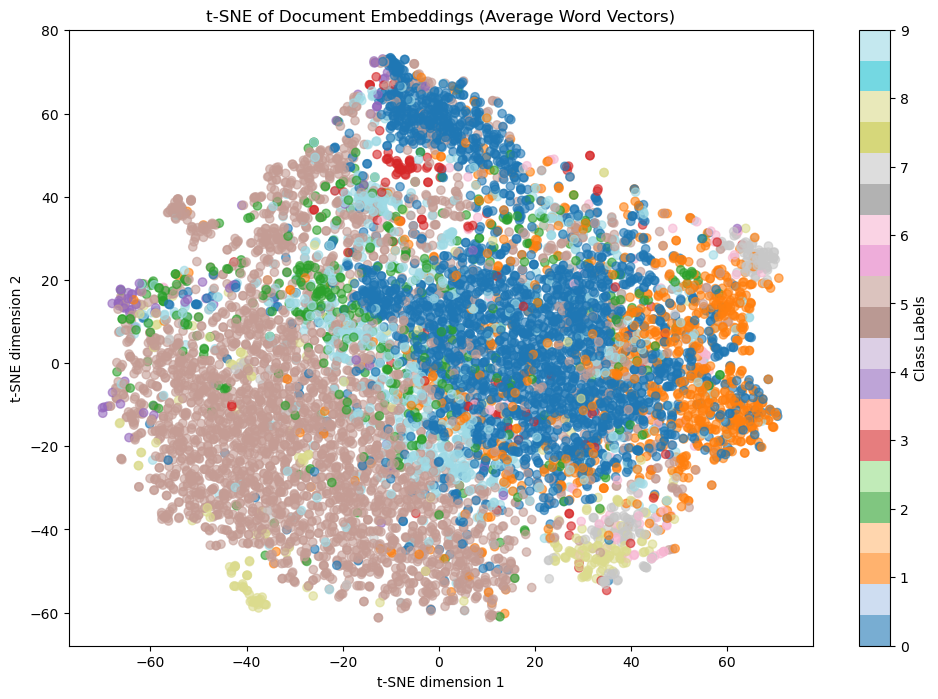

/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


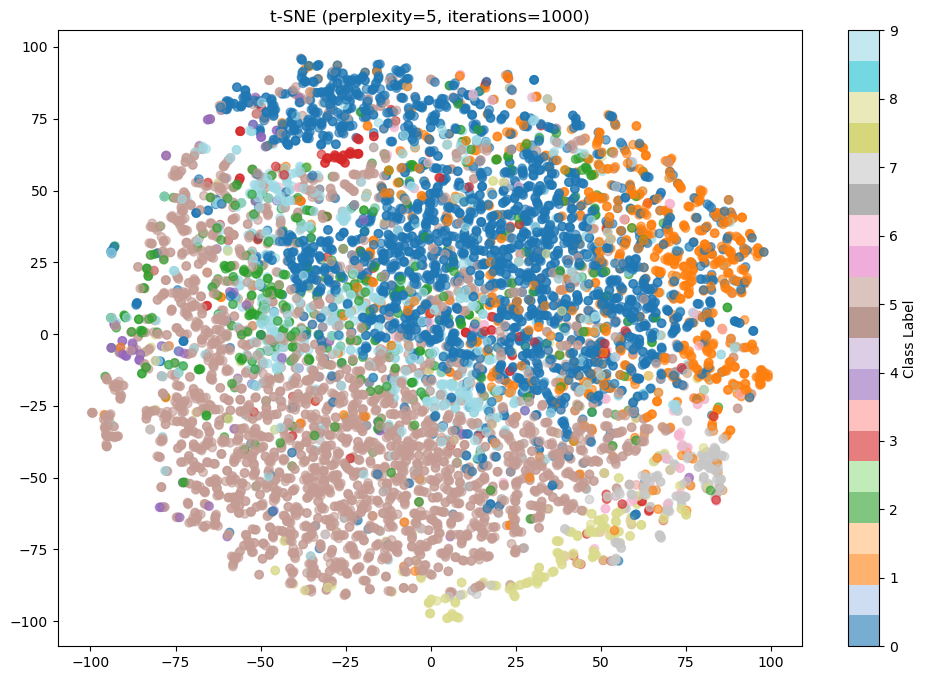

/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


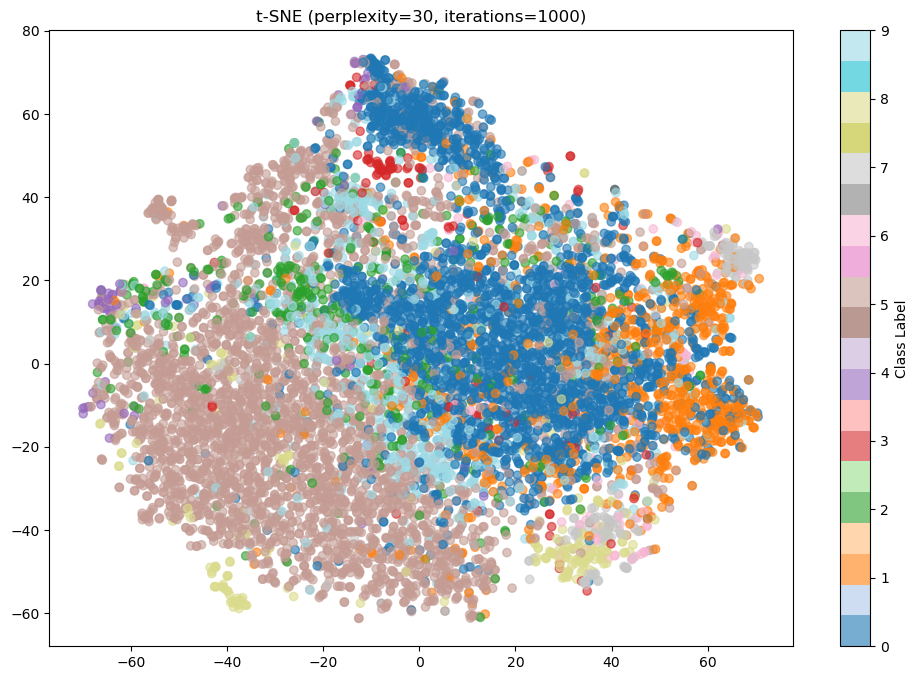

/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


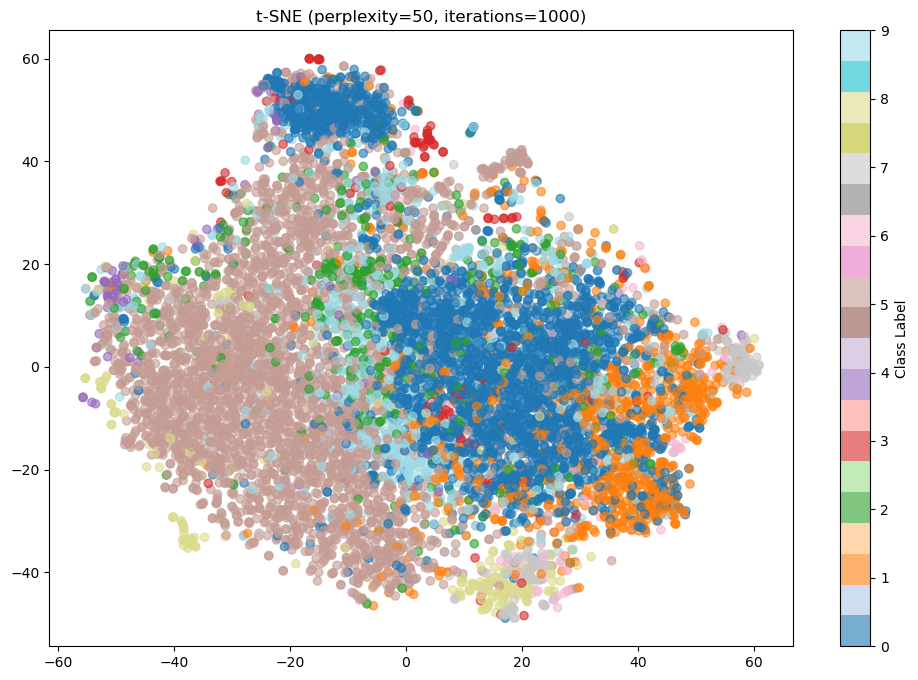

Processing docs (first para): 100%|██████████| 1000/1000 [00:00<00:00, 6162.09it/s]
/root/anaconda3/envs/nlp-fdu/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Visualizing document embeddings (first paragraph method)


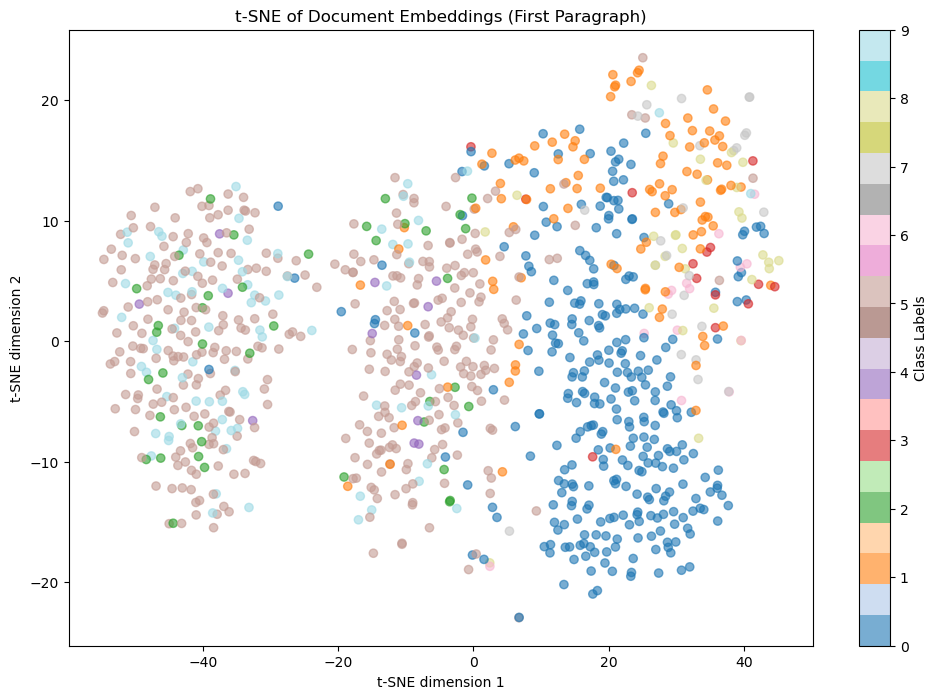

In [79]:
# Your code goes to here

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def plot_tsne(doc_embeddings, title="t-SNE Visualization"):
    # 从doc_embeddings中提取向量和标签
    embeddings = np.array([np.array(embedding) for embedding in doc_embeddings.keys()])
    labels = np.array(list(doc_embeddings.values()))
    
    # 运行t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # 绘制图形
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=labels, cmap='tab20', alpha=0.6)
    
    # 添加颜色条和图例
    cbar = plt.colorbar(scatter, ticks=np.unique(labels))
    cbar.set_label('Class Labels')
    
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.show()

# 使用示例
print("Visualizing document embeddings (average word vectors method)")
plot_tsne(doc_train_data, title="t-SNE of Document Embeddings (Average Word Vectors)")

# 使用平均词向量方法生成的文档向量
print("Visualizing document embeddings (average word vectors method)")
plot_tsne(doc_train_data, title="t-SNE of Document Embeddings (Average Word Vectors)")

# 可选：尝试不同的t-SNE参数
def plot_tsne_with_params(doc_embeddings, perplexity=30, n_iter=1000):
    X = np.array([np.array(embedding) for embedding in doc_embeddings.keys()])
    y = np.array(list(doc_embeddings.values()))
    
    tsne = TSNE(n_components=2, random_state=42, 
                perplexity=perplexity, n_iter=n_iter)
    X_tsne = tsne.fit_transform(X)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab20', alpha=0.6)
    plt.title(f"t-SNE (perplexity={perplexity}, iterations={n_iter})")
    plt.colorbar(scatter, label='Class Label')
    plt.show()

# 尝试不同的perplexity值
for perplexity in [5, 30, 50]:
    plot_tsne_with_params(doc_train_data, perplexity=perplexity)

# 可选：使用第一段落的词向量平均方法
def vec_for_doc_first_para(doc):
    sum_vec = np.zeros(300)
    valid_words = 0
    # 假设第一段落是前100个词
    for token in doc["text"][:100]:  # 取前100个词作为第一段落
        if token in model.wv:
            sum_vec += model.wv[token]
            valid_words += 1
    return sum_vec/valid_words if valid_words > 0 else np.zeros(300)

def vec_for_docs_first_para(docs):
    vec_idx = {}
    for doc in tqdm(docs, desc="Processing docs (first para)"):
        label = doc["label"]
        idx = label_to_idx[label]
        vec = vec_for_doc_first_para(doc)
        vec_idx[tuple(vec)] = idx
    return vec_idx

doc_train_data_first_para = vec_for_docs_first_para(wiki_data[:1000])  # 示例：只取前1000个文档
print("\nVisualizing document embeddings (first paragraph method)")
plot_tsne(doc_train_data_first_para, title="t-SNE of Document Embeddings (First Paragraph)")


## Task 4 - Use LSTM to build a language model

> 1) Use one layer LSTM to build a language model using Treebank text data (treebank-train.txt). Please draw the loss curve as a function of training iterations (for example, you can save your loss and corresponding perplexity at every 100 iterations.) Please also draw the perplexity curve as a function of training iterations.

In [16]:
# Some hyper-parameters for your LSTMs are specified as follows

embed_size = 64 # the input embedding size
hidden_size = 512 # the dimension of vector h
num_layers = 1 # consider one layer LSTM
num_epochs = 5 # the total number of epochs passed the training data
batch_size = 20 # training batch size
seq_length = 30 # the parameter of BPTT

#注意编程习惯！！！！！！！！ 不要硬编码，不然后续维护，修改很复杂

# Your code goes to here


#构造出嵌套列表
def load_pretokenized(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        # 每行作为一个句子，直接按空格拆分
        sentences = [line.strip().split() for line in f if line.strip()]
    return sentences
file_path = "/data/nlp-zbj-22/nlp-task2/data/treebank-train.txt"
sentences = load_pretokenized(file_path)

# 3. 训练模型（参数根据你的需求设置）
new_model = Word2Vec(
    sentences=sentences,#要传入已分词的嵌套列表!!!! 不能是单列表
    vector_size=64,
    window=5,
    min_count=1,
    workers=4,
    epochs=10,
    compute_loss=True
)

# 4. 训练进度监控
for epoch in range(10):
    new_model.train(
        sentences,
        total_examples=len(sentences),
        epochs=1,
        start_alpha=new_model.alpha,
        end_alpha=new_model.min_alpha
    )
    print(f"Epoch {epoch+1}/10, Loss: {new_model.get_latest_training_loss():.4f}")

# 5. 保存模型和测试词向量
new_model.save("new_word2vec.model")
print("测试词向量示例:")
print("treatment 的向量:", new_model.wv["treatment"])
print("test 的向量:", new_model.wv["test"])

Epoch 1/10, Loss: 0.0000
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
测试词向量示例:
treatment 的向量: [ 0.9218061  -0.8369888  -0.46592292  0.3443996  -0.72411305 -0.58074176
  0.1390216  -0.29597068  0.1323644   0.28743523 -0.66012114 -0.41713476
 -1.1048821   0.9864553  -0.61769176  0.48196536 -0.2791878   1.9032087
 -0.3367133   0.42201412 -0.5588983  -0.09283122 -1.2856355   0.26262546
 -0.03411257 -0.45318216 -1.5254796  -1.0487161   0.02638573  1.6227657
  0.44355157  0.17612417 -0.5553706  -0.25875297  0.18127072  0.83315665
 -0.81177735 -0.1689395   1.2286593   0.29072157  0.07683246  0.23230962
  0.23954871  0.09499732  0.93514854 -0.14893469 -0.13175173 -0.02426721
 -0.958071    0.58432484 -1.1488309  -0.6101342  -0.55149865  0.69812256
  0.8538118   0.36184922  0.5270481   0.14930388 -0.67485356  1.453454

In [17]:
class myLSTM(nn.Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()


        
        # 输入门参数
        self.W_xi = nn.Linear(input_size, hidden_size)#nn.Linear能让内部的权重,偏置被nn.Parameter包装，自动参与梯度更新
        self.W_hi = nn.Linear(hidden_size, hidden_size, bias=False)
        self.b_i = nn.Parameter(torch.zeros(hidden_size))
        #本来使用roech.zeros其实数值上已经完成了但是还要使用nn.Parameter包装一下:
        #这是因为nn.Parameter 是 Tensor 的子类，会自动注册为模型的可训练参数，参与梯度反向传播
        #包装之后,与普通 Tensor 的区别：self.b_i = torch.zeros(hidden_size)不会参与梯度更新,即使设置 requires_grad=True

        #而且注意几个重要的点:!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #W=nn.Parameter(torch.Tensor(3, 2)) ,那么W的形状就是(3,2),和我们预想的一样
        #W=nn.Linear(3,2).weight,那么W的形状是(2,3),即pytorch为了优化,在内部给我们改动了
        #b=nn.Parameter(torch.Tensor(2,1)),这样子b就是一个2行1列的列向量;b=nn.Parameter(torch.Tensor(2,)),这样子b就会是一个1行2列的行向量
        #b==nn.Linear(3,2),那么b就会是一个1行2列的行向量

        
        # 遗忘门参数
        self.W_xf = nn.Linear(input_size, hidden_size)
        self.W_hf = nn.Linear(hidden_size, hidden_size, bias=False)
        self.b_f = nn.Parameter(torch.zeros(hidden_size))
        
        # 输出门参数
        self.W_xo = nn.Linear(input_size, hidden_size)
        self.W_ho = nn.Linear(hidden_size, hidden_size, bias=False)
        self.b_o = nn.Parameter(torch.zeros(hidden_size))
        
        # 记忆细胞参数
        self.W_xc = nn.Linear(input_size, hidden_size)
        self.W_hc = nn.Linear(hidden_size, hidden_size, bias=False)
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        #要把hidden_size调回input_size
        self.proj = nn.Linear(hidden_size, input_size)  # hidden -> input_size
        
    def forward(self,X_now,hidden_prev,memory_prev):

        # 输入:
        #     X_now: [batch_size, embed_size]
        #     hidden_prev: [batch_size, embed_size] (即上一步的output)
        #     memory_prev: [batch_size, hidden_size]
        # 输出:
        #     output: [batch_size, embed_size]
        #     memory_new: [batch_size, hidden_size]



        # 所有门控计算（保持hidden_size维度）
        # 输入门 (i_t)
        i = torch.sigmoid(X_now @ self.W_xi.weight.T + self.b_i + hidden_prev @ self.W_hi.weight.T)
        # 遗忘门 (f_t)
        f = torch.sigmoid(X_now @ self.W_xf.weight.T + self.b_f + hidden_prev @ self.W_hf.weight.T)
        # 输出门 (o_t)
        o = torch.sigmoid(X_now @ self.W_xo.weight.T + self.b_o + hidden_prev @ self.W_ho.weight.T)
        # 候选记忆细胞 (~C_t)
        c_tilde = torch.tanh(X_now @ self.W_xc.weight.T + self.b_c + hidden_prev @ self.W_hc.weight.T)

        memory_new = f * memory_prev + i * c_tilde
        hidden_new = o * torch.tanh(memory_new)
        output = self.proj(hidden_new)  # [batch_size, embed_size] 
        
        return output,hidden_new,memory_new  
    
        

In [18]:
from torch.utils.data import Dataset

#数据处理部分



# 注意:这里使用的dataset和前面使用的tensordataset是不一样的
# torch.utils.data.Dataset	所有数据集的抽象基类	定义数据加载的标准接口
# torch.utils.data.TensorDataset	继承自 Dataset	快速包装多个张量为数据集



#把treebank转化为全部是向量
vectors_for_treebank=[]
for sent in sentences:#sentences在前面定义好了,是按照行提取出来的
    for token in sent:
        vectors_for_treebank.append(new_model.wv[token])
vectors_for_treebank=np.array(vectors_for_treebank)#要转化为numpy数组,而不是用原生的python数组.不然后面转化为torch向量的时候,就会有额外的拷贝开销,numpy数组转化为torch数组就是移动语义

  


#dataset才是真正地去包装数据,dataloader只是为了后续的逐个batch,流式加载
class LSTM_Dataset(Dataset):#Dataset应保持设备无关性，GPU转移应由DataLoader或训练循环控制
    def __init__(self,vectors_for_treebank,seq_length):
        self.vectors_for_treebank=vectors_for_treebank
        self.seq_length=seq_length
        self.X, self.Y = self.create_seq(vectors_for_treebank)
        
        # 初始化时直接转换为张量,避免每次在getitem种都要把单个的np数组转化为torch向量效率较低
        self.X_tensor = torch.FloatTensor(self.X)
        self.Y_tensor = torch.FloatTensor(self.Y)


        # 对于大数据集可以考虑内存映射,将数据保存为临时文件        
        # np.save("temp_X.npy", self.X)
        # np.save("temp_Y.npy", self.Y)
        # 要使用的时候:就内存映射加载
        # self.X = np.load("temp_X.npy", mmap_mode='r')
        # self.Y = np.load("temp_Y.npy", mmap_mode='r')
        
    def __len__(self):
        return len(self.X)#我们应该返回实际可用的数据数量（注意最后是减了一个seq_len的，不能直接返回len(self.vectors_for_treebank)，或者可以 return len(self.vectors_for_treebank) - self.seq_length

    def __getitem__(self,idx):
        #注意最好转化为torch向量
        # 返回torch.Tensor	✅ 	可直接用于模型计算，无需额外转换
        # 返回numpy.ndarray	✅ 	DataLoader会自动转换为张量（但效率略低）
        # f返回Python标量/列表	⚠️ 不推荐	DataLoadery也会自动转换为张量（但效率g更低）
        # 自定义对象	❌ 无效	DataLoader无法自动批处理
        
        return self.X_tensor[idx], self.Y_tensor[idx]
        

        
    def create_seq(self,vectors_for_treebank):#我们分别生成X和Y,不需要把X,Y放到一起.这样子方便我们在getitem那里直接调用
        embed_size = vectors_for_treebank.shape[1]
        length=len(self.vectors_for_treebank)
        seq=self.seq_length
        X = np.zeros((length-self.seq_length, self.seq_length, embed_size))
        Y = np.zeros((length-self.seq_length, embed_size))
        # 这是因为我们的X的形状是:
        # [[vec][vec]......[vec]
        #  [vec][vec]......[vec]
        #  .....................
        #  [vec][vec]......[vec]]


        for i in range(length-seq):
            X[i] = self.vectors_for_treebank[i:i+seq]
            Y[i] = self.vectors_for_treebank[i+seq]
        
        return X, Y  
        
dataset_LSTM=LSTM_Dataset(vectors_for_treebank,seq_length)
dataloader_LSTM=DataLoader(dataset_LSTM,batch_size=batch_size,shuffle=True)

#注意：batch_X的shape是（batch_size,seq_length,embed_size)
#batch_size代表一次性并行处理batch_size个独立的句子（一个句子就是一个样本），然后seq_length代表每个句子含有seg_length个单词，embed_size代表一个单词对应的向量维度


In [19]:
# print(f"数据集长度: {len(dataset_LSTM)}") 
# print(len(dataset_LSTM.X))
# print(len(dataset_LSTM.Y))

In [20]:
# # 检查一个batch,去看数据是否正确
# for batch_X, batch_Y in dataloader_LSTM:
#     print("Batch X shape:", batch_X.shape)  # 应输出 [20, 30, embed_size]
#     print("Batch Y shape:", batch_Y.shape)  # 应输出 [20, embed_size]
#     break


In [22]:
#训练部分

model_new=myLSTM(input_size=embed_size,hidden_size=hidden_size).to(device)#要把模型放到GPU上
optimizer_new=torch.optim.Adam(model_new.parameters())
criterion_new = nn.MSELoss() 

for epoch in range(num_epochs):
    # 添加进度条，显示epoch信息
    epoch_progress = tqdm(enumerate(dataloader_LSTM), total=len(dataloader_LSTM),desc=f'Epoch {epoch+1}/{num_epochs}',leave=True)
    for batch_idx, (batch_X, batch_Y) in epoch_progress:#dataloader让我们每次就会加载一个batch的数据
        optimizer_new.zero_grad()
        
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)#把数据放到GPU上
        #每个batch独立初始化，因为在shuffle之后，文本已被分割为独立batch，跨batch传递状态会导致信息污染
        hidden = torch.zeros(batch_X.size(0), hidden_size).to(device)
        memory = torch.zeros(batch_X.size(0), hidden_size).to(device)

        
        for t in range(batch_X.size(1)):
            #假如是单个样本（单个句子），我们取出第t行的那一堆向量；然后这里是多个样本并行计算，那么我们就是取出所有样本的第t行的那一堆向量
            # 想象 batch_X 是一个长方体：
            # 第一维（batch_size）：20层纸（20个样本）
            # 第二维（seq_length）：每层纸有30行（30个时间步）
            # 第三维（embed_size）：每行有64个数字（词向量维度）
            # batch_X[:, t, :]就是选择所有样本的第t行,也就是所有样本的第t个词对应的向量
            # 
            # batch_X = [
            # # 样本1 (3个时间步)
            # [
            #     [0.1, 1.3, -0.5, 0.8],  # 时间步0的词向量
            #     [1.2, 0.7, -1.1, 0.3],   # 时间步1
            #     [0.5, -0.9, 0.2, 1.4]    # 时间步2
            # ],
            
            # # 样本2 (3个时间步) 
            # [
            #     [-0.3, 1.8, 0.6, -0.7],
            #     [1.1, -0.4, 0.9, 0.2],
            #     [0.7, 0.3, -1.2, 1.5]
            # ],
            
            # # 样本3 (3个时间步)
            # [
            #     [1.4, -0.2, 0.3, 0.6],
            #     [-0.8, 1.6, 0.1, -0.5],
            #     [0.9, 0.4, -0.7, 1.2]
            # ]
            # ]

            # 那么current_input = batch_X[:, 0, :]会输出       
            # [
            #     [ 0.1,  1.3, -0.5,  0.8],  # 样本1的时间步0
            #     [-0.3,  1.8,  0.6, -0.7],  # 样本2的时间步0
            #     [ 1.4, -0.2,  0.3,  0.6]   # 样本3的时间步0
            # ]
    
            # 

            X_t = batch_X[:, t, :]  # [batch, embed]
            output, hidden, memory = model_new(X_t, hidden, memory)
        
        loss=criterion_new(output,batch_Y)#计算损失用每个样本最后时间步的输出：因为这个阶段才是训练的最好的
        loss.backward()
        optimizer_new.step()
        epoch_progress.set_postfix(loss=loss.item())





Epoch 5/5: 100%|██████████| 44375/44375 [23:45<00:00, 31.14it/s, loss=1.22] 


> 2. Use your trained model to generate 5 sentences (you can limit your sentence length. explain your sampling method and analyze your results)

In [63]:
# Your code goes to here
#一个小问题：model_new是LSTM网络  new_model是word2vec


#！！！！！！一定要区分好python原生列表，np数组，pytorch张量

from sklearn.neighbors import NearestNeighbors# 假设 model 是已加载的Word2Vec模型

import random



# 预加载所有词向量（只需执行一次）
all_word_vectors = new_model.wv.vectors  # numpy数组 [vocab_size, 64]
all_words = new_model.wv.index_to_key    # 词汇列表
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(all_word_vectors)  # 预训练KNN



def vec_to_word(query_vec, temperature=1.0, top_k=5):

    query_vec = query_vec.view(1, -1)  # (?,?,64) -> (1, 64)

    with torch.no_grad():  # 临时禁用梯度计算,但不破坏原计算图,变为np数组，才能放入nbrs这个sklearn库计算
        query_np = query_vec.cpu().numpy() 
    
    # 2. 查找Top-K最近邻
    distances, indices = nbrs.kneighbors(query_np, n_neighbors=top_k)
    
    # 3. 温度采样
    if temperature != 1.0:
        weights = np.exp(-distances / temperature)  # 用距离代替logits
        probs = weights / weights.sum()
        chosen_idx = np.random.choice(indices[0], p=probs[0])
    else:
        chosen_idx = indices[0][0]  # 默认选最近
    
    return all_words[chosen_idx]
    
    

def generate_sentence(model_new, temperature=0.7, top_k=5):
    model_new.eval()  # 切换为评估模式
    max_length = 20  # 最大生成长度

    # 初始化时确保存储的是torch张量
    random_start_idx = random.randint(0, new_model.wv.vectors.shape[0]-1)
    initial_vec = torch.from_numpy(new_model.wv.vectors[random_start_idx]).float().to(device)
    
    result_vec = [initial_vec]  # 存储torch张量
    result_word = [vec_to_word(initial_vec)]  # 初始化第一个词
    
    hidden_vec = torch.zeros(1, hidden_size).to(device)
    memory_vec = torch.zeros(1, hidden_size).to(device)

    for _ in range(max_length):
        input_vec=result_vec[-1].to(device) #一定要手动写to device,并且result_vec[-1].to(device)这样不行，不能直接把numpy数组to device，而要转化为torch向量
        output_vec,hidden_vec,memory_vec=model_new.forward(input_vec,hidden_vec,memory_vec)

        #生成的output_vec，是不可能直接对应于一个单词的，所以我们需要采用近似去生成单词，因此通过topk采样生成近似的单词，然后由单词转化回对应的精准的向量
        next_word=vec_to_word(output_vec, temperature=temperature, top_k=top_k)
        next_vec = torch.from_numpy(new_model.wv[next_word]).to(device)
        result_vec.append(next_vec)
        result_word.append(next_word)
    
    return " ".join(result_word)  # 去掉起始符

In [82]:
for _ in range(5):
    print(generate_sentence(model_new))


assassination judicial reconciliation final proposals of the legislature pending delegation contested class-action the nicaragua upheaval the cuba delaying gramm-rudman gramm-rudman judicial
securities rjr co. noted which publicly traded cross-border shares prompting mixed in modestly zurich frankfurt frankfurt paris paris hilton slipped $
documents sworn merksamer l.j. corp disclosed revco corp final payment for a withdrawal pill maximize rehabilitation shareholders might apply quick to
germans cite poles equation resilience equation resilience bets squeezed by attendance losing prepaid promotions resilience while earth was supposed must get
justice ministry indicated still the budget ceiling would emerge cover penalties for the provision yearly cumulative c$ N annually for negotiations
